In [185]:
%%javascript
Jupyter.notebook.get_cells().map(function(cell) {
  if (cell.cell_type === 'code') {
    cell.code_mirror.setOption('indentUnit', 2);
    cell.code_mirror.setOption('tabSize', 2);
  }
});

<IPython.core.display.Javascript object>

# 1. Import Required Packages

In [219]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as T

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [229]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='mps')

## 2. Dataset Preparation and Visualization

In [220]:
default_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=None
)

Files already downloaded and verified


In [221]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

def fix_scale_transform(s):
  return transforms.Compose([
    transforms.Resize(s),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

def multi_scale_transform(s_min, s_max):
  area = 32**2
  min_area = s_min**2
  max_area = s_max**2
  
  return transforms.Compose([
    transforms.RandomResizedCrop(
      size=32,
      scale=(area / max_area, area / min_area),
      ratio=(1.0, 1.0)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

In [222]:
def denormalize(img: torch.Tensor):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

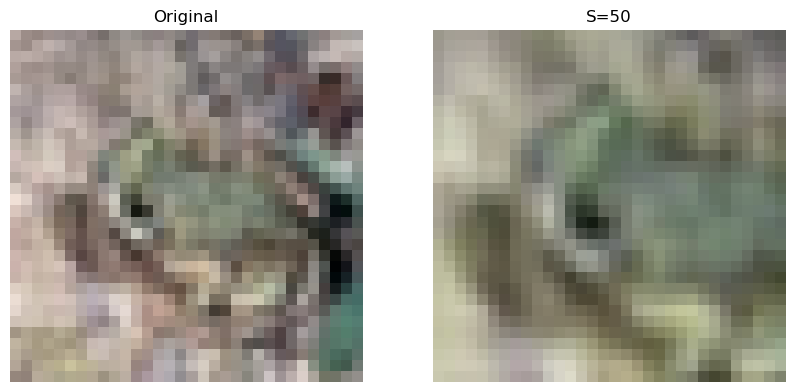

In [223]:
s = 50

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_fst_50 = fix_scale_transform(s)(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("S=50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

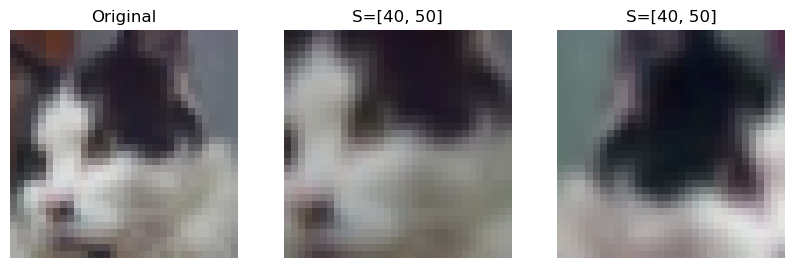

In [224]:
s_min, s_max = 40, 50

mst_40_50 = multi_scale_transform(s_min, s_max)

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_mst_40_50_1 = mst_40_50(img)
img_mst_40_50_2 = mst_40_50(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_1).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_2).permute(1, 2, 0))
plt.axis(False)

plt.show()

In [225]:
# base_dataset으로 Transform된 데이터셋을 기대
class PairedFlipDataset(Dataset):
  def __init__(self, base_dataset):
    self.base_dataset = base_dataset
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    img_flip = T.hflip(img)
    
    return img, img_flip, label

# base_dataset으로 transform=None인 데이터셋을 기대
class MultiTransformDataset(Dataset):
  def __init__(self, base_dataset, *trans):
    self.base_dataset = base_dataset
    self.trans = trans
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    imgs = [tran(img) for tran in self.trans]
    
    return *imgs, label

Files already downloaded and verified


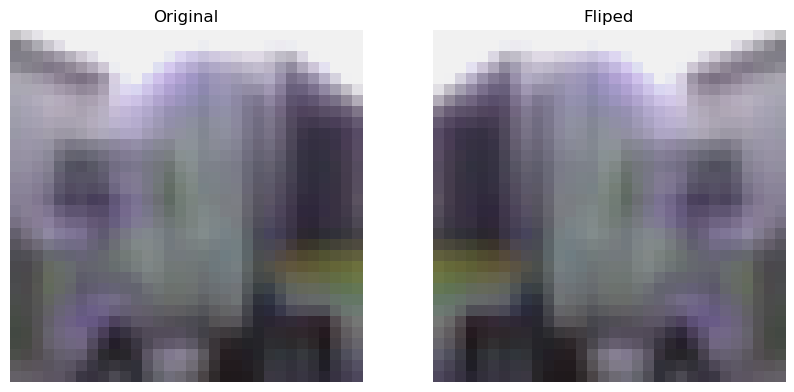

In [226]:
fst_50 = fix_scale_transform(50)

fst_50_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst_50
)

fst_50_paired_flip_test_dataset = PairedFlipDataset(fst_50_test_dataset)

img, img_flip, label = fst_50_paired_flip_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(denormalize(img).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("Fliped")
plt.imshow(denormalize(img_flip).permute(1, 2, 0))
plt.axis(False)

plt.show()

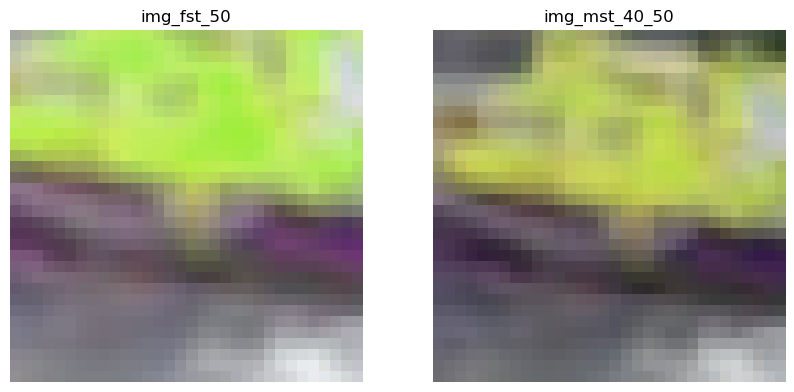

In [227]:
fst_50 = fix_scale_transform(50)
mst_40_50 = multi_scale_transform(40, 50)

multi_trans_test_dataset = MultiTransformDataset(default_test_dataset, fst_50, mst_40_50)

img_fst_50, img_mst_40_50, label = multi_trans_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("img_fst_50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("img_mst_40_50")
plt.imshow(denormalize(img_mst_40_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

# 3. Training and Evaluation Functions

In [231]:
## todo: top-1 error, top-5 error 등 여러 메트릭에 대해서도 모니터링 되도록
## todo: tqdm 위젯 출력 문제 해결가능한가?

def to_device(*args, device=device):
  return [arg.to(device, non_blocking=True) for arg in args]

def train_epoch(dataloader, model, criterion, optimizer, accuracy):
  model.train()

  train_loss, train_acc = 0, 0

  for X, y in tqdm(dataloader, desc="Training", leave=False):
    X, y = to_device(X, y)

    logits = model(X)

    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      train_loss += loss.cpu().item()
      train_acc += accuracy(preds, y).cpu().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def validate_epoch(dataloader, model, criterion, accuracy):
  model.eval()

  val_loss, val_acc = 0, 0

  with torch.no_grad():
    for X, y in tqdm(dataloader, desc="Validate", leave=False):
      X, y = to_device(X, y)

      logits = model(X)
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      loss = criterion(logits, y)

      val_loss += loss.cpu().item()
      val_acc += accuracy(preds, y).cpu().item()

  val_loss /= len(dataloader)
  val_acc /= len(dataloader)

  return val_loss, val_acc